In [1]:
import pandas as pd
import logging
from typing import Optional
import matplotlib.pyplot as plt

import numpy as np

import seaborn as sns
from scipy import stats
from statsmodels.graphics.gofplots import qqplot
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
download = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet')

## Homework



The goal of this homework is to train a simple model for predicting the duration of a ride - similar to what we did in this module.


## Q1. Downloading the data

We'll use [the same NYC taxi dataset](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page),
but instead of "**Green** Taxi Trip Records", we'll use "**Yellow** Taxi Trip Records".

Download the data for January and February 2023.

Read the data for January. How many columns are there?

* 16
* 17
* 18
* 19 <<<<




In [2]:

len(download.columns)

19

There are 19 columns in January 2023

## Q2. Computing duration

Now let's compute the `duration` variable. It should contain the duration of a ride in minutes.

What's the standard deviation of the trips duration in January?

* 32.59
* 42.59 <<<<<<<<<
* 52.59
* 62.59

In [3]:
import logging
import pandas as pd
from typing import Optional

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def read_dataframe_1(df: pd.DataFrame) -> Optional[pd.DataFrame]:
    """Process taxi trip dataframe with type validation and logging.

    Args:
        df: Raw DataFrame with taxi trip columns.

    Returns:
        Processed DataFrame or None if validation fails with duration as a new feature.
    """
    try:
        # Validate input
        required_columns = {'tpep_pickup_datetime', 'tpep_dropoff_datetime',
                           'PULocationID', 'DOLocationID'}
        if not required_columns.issubset(df.columns):
            missing = required_columns - set(df.columns)
            logger.error(f"Missing required columns: {missing}")
            return None

        df = df.copy()
        df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
        df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])
        logger.info("Datetime conversion completed")

        df['duration'] = (
            df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']
        ).dt.total_seconds() / 60
        logger.info("Duration calculation completed")

        categorical = ['PULocationID', 'DOLocationID']
        df[categorical] = df[categorical].astype('string')
        logger.info("Type conversion to string completed")

        return df

    except Exception as e:
        logger.error(f"Processing failed: {str(e)}", exc_info=True)
        return None


q2 = read_dataframe_1(download)

q2['duration'].std()

INFO:__main__:Datetime conversion completed
INFO:__main__:Duration calculation completed
INFO:__main__:Type conversion to string completed


np.float64(42.59435124195458)

Standard Deviation of Trip Duration: 42.59 minutes


## Q3. Dropping outliers

Next, we need to check the distribution of the `duration` variable. There are some outliers. Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive).

What fraction of the records left after you dropped the outliers?

* 90%
* 92%
* 95%
* 98% <<<<<<<<<<<

In [4]:

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def read_dataframe(df: pd.DataFrame) -> Optional[pd.DataFrame]:
    """Process taxi trip dataframe with type validation and logging.

    Args:
        df: Raw DataFrame with taxi trip columns.

    Returns:
        Processed DataFrame or None if validation fails with duration as a new feature.
    """
    try:
        # Validate input
        required_columns = {'tpep_pickup_datetime', 'tpep_dropoff_datetime',
                           'PULocationID', 'DOLocationID'}
        if not required_columns.issubset(df.columns):
            missing = required_columns - set(df.columns)
            logger.error(f"Missing required columns: {missing}")
            return None


        df = df.copy()
        df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
        df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])
        logger.info("Datetime conversion completed")


        df['duration'] = (
            df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']
        ).dt.total_seconds() / 60
        logger.info("Duration calculation completed")


        df = df[(df['duration'] >= 1) & (df['duration'] <= 60)].copy()
        logger.info(f"Filtered to {len(df)} valid trips")


        categorical = ['PULocationID', 'DOLocationID']
        df[categorical] = df[categorical].astype('string')
        logger.info("Type conversion to string completed")

        return df

    except Exception as e:
        logger.error(f"Processing failed: {str(e)}", exc_info=True)
        return None

df = read_dataframe(download)

print(f"Unfiltered: {q2.shape[0]}, Filtered: {df.shape[0]}, Dropped: {q2.shape[0] - df.shape[0]}, Percentage Dropped: {((q2.shape[0] - df.shape[0]) / q2.shape[0] * 100):.2f}%")

INFO:__main__:Datetime conversion completed


INFO:__main__:Duration calculation completed
INFO:__main__:Filtered to 3009173 valid trips
INFO:__main__:Type conversion to string completed


Unfiltered: 3066766, Filtered: 3009173, Dropped: 57593, Percentage Dropped: 1.88%


98% is left after dropping outliers

## Q4. One-hot encoding

Let's apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model.

* Turn the dataframe into a list of dictionaries (remember to re-cast the ids to strings - otherwise it will
  label encode them)
* Fit a dictionary vectorizer
* Get a feature matrix from it

What's the dimensionality of this matrix (number of columns)?

* 2
* 155
* 345
* 515 <<<<<<<<<<<<<<<<<
* 715

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error

def prepare_training_data(df: pd.DataFrame, categorical: list = ['PULocationID', 'DOLocationID'],
                         numerical: list = None, target: str = 'duration'):
    """Prepare training data by vectorizing categorical features, including numerical features, and extracting target.

    Args:
        df: Processed DataFrame with categorical, numerical, and target columns.
        categorical: List of categorical column names. Defaults to ['PULocationID', 'DOLocationID'].
        numerical: List of numerical column names. Defaults to None.
        target: Name of the target column. Defaults to 'duration'.

    Returns:
        Tuple of (X_train, y_train, dv) where:
            X_train: Transformed feature matrix.
            y_train: Target array.
            dv: Fitted DictVectorizer.
    """

    df = df.copy()


    df[categorical] = df[categorical].astype(str)


    train_dicts = df[categorical].to_dict(orient='records')


    dv = DictVectorizer()


    X_train = dv.fit_transform(train_dicts)


    if numerical:
        X_numerical = df[numerical].to_numpy()
        from scipy.sparse import hstack
        X_train = hstack([X_train, X_numerical])


    y_train = df[target].values

    return X_train, y_train, dv





categorical_features = ['PULocationID', 'DOLocationID']

target = 'duration'


X_train, y_train, dv = prepare_training_data(df, categorical=categorical_features,
                                             target=target)


print(f"Feature matrix dimensionality: {X_train.shape[1]} features (columns)")
print(f"Number of samples: {X_train.shape[0]}")




Feature matrix dimensionality: 515 features (columns)
Number of samples: 3009173


## Q5. Training a model

Now let's use the feature matrix from the previous step to train a model.

* Train a plain linear regression model with default parameters, where duration is the response variable
* Calculate the RMSE of the model on the training data

What's the RMSE on train?

* 3.64
* 7.64 <<<<<<<<<<<<<<<<<<
* 11.64
* 16.64

Root Mean Squared Error: 7.65


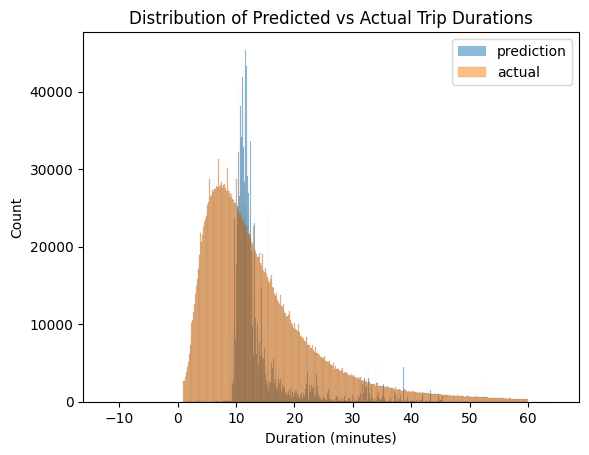

: 

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)


y_pred = lr.predict(X_train)


rmse = root_mean_squared_error(y_train, y_pred)
print(f"Root Mean Squared Error: {rmse:.2f}")


sns.histplot(y_pred, label='prediction', alpha=0.5)
sns.histplot(y_train, label='actual', alpha=0.5)
plt.legend()
plt.xlabel('Duration (minutes)')
plt.title('Distribution of Predicted vs Actual Trip Durations')
plt.show()

## Q6. Evaluating the model

Now let's apply this model to the validation dataset (February 2023).

What's the RMSE on validation?

* 3.81
* 7.81 <<<<<<<<<<<
* 11.81
* 16.81

## Submit the results

* Submit your results here: https://courses.datatalks.club/mlops-zoomcamp-2025/homework/hw1
* If your answer doesn't match options exactly, select the closest one

In [ ]:
val_set = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet')
val_df = read_dataframe(val_set)

INFO:__main__:Datetime conversion completed
INFO:__main__:Duration calculation completed


Root Mean Squared Error: 7.82


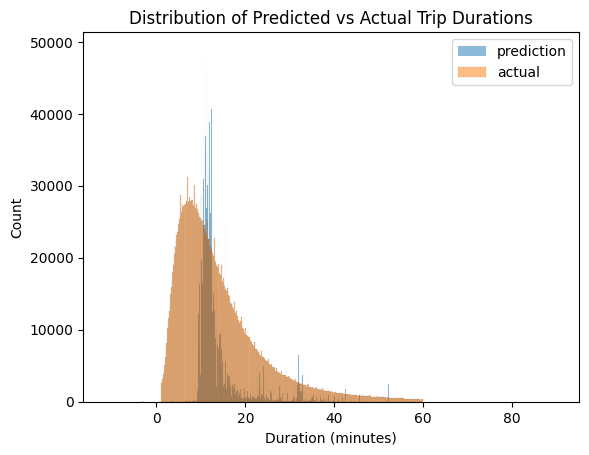

In [ ]:
import pandas as pd
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt

def process_train_val_data(df_train: pd.DataFrame, df_val: pd.DataFrame,
                          categorical: list,
                          numerical: list = ['trip_distance'],
                          target: str = 'duration'):
    """Process training and validation DataFrames by vectorizing specified features.

    Args:
        df_train: Training DataFrame with feature and target columns.
        df_val: Validation DataFrame with feature and target columns.
        categorical: List of categorical column names (required).
        numerical: List of numerical column names. Defaults to ['trip_distance'].
        target: Name of the target column. Defaults to 'duration'.

    Returns:
        Tuple of (X_train, y_train, X_val, y_val, dv) where:
            X_train: Transformed training feature matrix.
            y_train: Training target array.
            X_val: Transformed validation feature matrix.
            y_val: Validation target array.
            dv: Fitted DictVectorizer.
    """
    # Copy DataFrames to avoid modifying originals
    df_train = df_train.copy()
    df_val = df_val.copy()

    # Convert categorical features to strings
    df_train[categorical] = df_train[categorical].astype(str)
    df_val[categorical] = df_val[categorical].astype(str)

    # Combine categorical and numerical features
    features = categorical + numerical

    # Convert to dictionaries for vectorization
    train_dicts = df_train[features].to_dict(orient='records')
    val_dicts = df_val[features].to_dict(orient='records')

    # Initialize and fit DictVectorizer
    dv = DictVectorizer()
    X_train = dv.fit_transform(train_dicts)
    X_val = dv.transform(val_dicts)

    # Extract target arrays
    y_train = df_train[target].values
    y_val = df_val[target].values

    return X_train, y_train, X_val, y_val, dv

# Example usage
# Assuming df and val_set are your processed DataFrames
categorical = ['PULocationID', 'DOLocationID']  # Manually specify categorical features
X_train, y_train, X_val, y_val, dv = process_train_val_data(df, val_df, categorical=categorical)

# Train linear regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Make predictions on validation set
y_pred = lr.predict(X_val)

# Calculate RMSE
rmse = root_mean_squared_error(y_val, y_pred)
print(f"Root Mean Squared Error: {rmse:.2f}")

# Visualize predictions vs actual
sns.histplot(y_pred, label='prediction', alpha=0.5)
sns.histplot(y_train, label='actual', alpha=0.5)  # Note: Using y_train as in original code
plt.legend()
plt.xlabel('Duration (minutes)')
plt.title('Distribution of Predicted vs Actual Trip Durations')
plt.show()

In [ ]:
plt.figure(figsize=(14, 6))

# Original
plt.subplot(1, 2, 1)
sns.histplot(df['duration'], kde=True, color='skyblue')
plt.axvline(df['duration'].mean(), color='red', linestyle='--', label=f'Mean: {df["duration"].mean():.1f} min')
plt.axvline(df['duration'].median(), color='green', linestyle='--', label=f'Median: {df["duration"].median():.1f} min')
plt.title('Original Distribution', fontsize=14)
plt.xlabel('Duration (minutes)')
plt.ylabel('Count')
plt.legend()

# Log-Transformed
plt.subplot(1, 2, 2)
log_duration = np.log1p(df['duration'])
sns.histplot(log_duration, kde=True, color='salmon')
plt.axvline(log_duration.mean(), color='red', linestyle='--', label=f'Mean: {log_duration.mean():.1f} log(min)')
plt.axvline(log_duration.median(), color='green', linestyle='--', label=f'Median: {log_duration.median():.1f} log(min)')
plt.title('Log-Transformed Distribution', fontsize=14)
plt.xlabel('log(Duration + 1)')
plt.ylabel('Count')
plt.legend()

sns.despine()
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))


df['log_duration'] = np.log1p(df['duration'])


sns.boxplot(x=df['log_duration'], color='lightblue', whis=1.5)


plt.axvline(df['log_duration'].median(), color='red', linestyle='--', label='Median')
plt.title('Trip Duration (Log Scale)', fontsize=14)
plt.xlabel('log(1 + Duration in minutes)')


log_ticks = [0, 1, 2, 3, 4]  #  durations of ~1, 2, 7, 20, 55 minutes
plt.xticks(log_ticks, [f"{np.expm1(x):.0f}" for x in log_ticks])
plt.gca().set_xticklabels([f"{np.expm1(x):.0f} min" for x in log_ticks], rotation=45)
plt.ylabel('')

sns.despine()
plt.tight_layout()
plt.show()

a log transformation will help us predict trip duration more effectively

In [ ]:
plt.figure(figsize=(10, 4))
sns.boxplot(x=df['duration'], color='lightgreen')
plt.title('Trip Duration - Outlier Detection', fontsize=14)
plt.xlabel('Duration (minutes)')
sns.despine()
plt.show()


q1, q3 = df['duration'].quantile([0.25, 0.75])
iqr = q3 - q1
print(f"Outlier thresholds:\nBelow {q1 - 1.5*iqr:.1f} min or above {q3 + 1.5*iqr:.1f} min")

We see we have plenty of outliers using a traditional IQR. This seems restrictive.

In [ ]:
plt.figure(figsize=(10, 6))
qqplot(df['duration'], line='s')
plt.title('Q-Q Plot: Normality Assessment', fontsize=14)
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
sns.despine()
plt.show()

# Normality test
stat, p = stats.shapiro(df['duration'].sample(min(5000, len(df))))  # Limit sample size for performance
print(f"Normality test: p-value = {p:.3f} ({'Not normal' if p < 0.05 else 'Normal'})")

In [ ]:
def calculate_optimal_range(series: pd.Series, iqr_factor: float = 1.5) -> tuple[float, float]:
    """
    Dynamically calculates display range using IQR with adjustable sensitivity.

    Args:
        series: Input data (trip durations)
        iqr_factor: Controls outlier tolerance (1.5=standard, higher=wider range)

    Returns:
        (lower_bound, upper_bound) for optimal visualization
    """
    q1, q3 = series.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower_bound = max(series.min(), q1 - iqr_factor * iqr)
    upper_bound = min(series.max(), q3 + iqr_factor * iqr)
    return lower_bound, upper_bound




In [ ]:
lower, upper = calculate_optimal_range(df['duration'], iqr_factor=1.8)
plt.figure(figsize=(10,4))
plt.hist(df['duration'], bins=50, alpha=0.7)
plt.axvspan(df['duration'].mean() - duration_std,
            df['duration'].mean() + duration_std,
            color='red', alpha=0.2, label='±1 Std Dev')
plt.axvspan(lower, upper, color='green', alpha=0.2, label='IQR Range')
plt.legend()
plt.show()


In [ ]:
plt.figure(figsize=(12, 6))


sns.boxplot(x=df['duration'], whis=1.8, color='lightblue')  # whis=1.8 matches our IQR factor


plt.axvspan(df['duration'].mean() - duration_std,
            df['duration'].mean() + duration_std,
            color='red', alpha=0.2, label=f'±1 Std Dev ({duration_std:.1f} mins)')
plt.axvspan(lower, upper,
            color='green', alpha=0.2, label=f'IQR Range ({lower:.1f}-{upper:.1f} mins)')


plt.text(df['duration'].mean(), plt.ylim()[1]*0.9,
         f"Mean: {df['duration'].mean():.1f}", ha='center', backgroundcolor='white')
plt.text(df['duration'].median(), plt.ylim()[1]*0.85,
         f"Median: {df['duration'].median():.1f}", ha='center', backgroundcolor='white')

plt.title('Trip Duration: Boxplot with Range Comparison', fontsize=14)
plt.xlabel('Duration (minutes)')
plt.legend(bbox_to_anchor=(1, 1))
sns.despine()
plt.tight_layout()
plt.show()

Since StanDev is not representative of right skewed taxi rides, we can therefore use IQR for a better representation. Our next step is to find out which IQR approach better suits our needs. Since IQR describes the middle 50% of data (q1-q3) and 1.5x IQR captures mild outliers, we have a less restrictive and more representative image of our data. Since some rides can be longer, and this is to be expected, StDv would consider these as outliers, this would be a tad out of touch. This is because StDv is best for symmetric (normal) distributions and IQR does better with skewed data with outliers.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Filter invalid durations
df = df[df['duration'] > 0].copy()

# Transformations
df['log_duration'] = np.log(df['duration'])
df['cuberoot_duration'] = np.cbrt(df['duration'])

# Setup plot
fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
plt.suptitle('Trip Duration Outlier Detection Comparison', y=1.02)

# Calculate shared x-axis limits
global_min = min(df['duration'].min(), np.exp(df['log_duration'].min()), df['cuberoot_duration'].min()**3)
global_max = max(df['duration'].max(), np.exp(df['log_duration'].max()), df['cuberoot_duration'].max()**3)

# -------------------------------------
# 1. Original Scale
# -------------------------------------
sns.boxplot(x=df['duration'], ax=axes[0], color='skyblue', whis=1.5)
axes[0].set_title('Original Scale (minutes)', pad=10)
axes[0].set_xlabel('')
axes[0].set_xlim(global_min, global_max)

# Mark IQR bounds
q1, q3 = df['duration'].quantile([0.25, 0.75])
iqr = q3 - q1
orig_lower = max(0, q1 - 1.5*iqr)
orig_upper = q3 + 1.5*iqr
axes[0].axvline(orig_lower, color='red', linestyle=':', alpha=0.7)
axes[0].axvline(orig_upper, color='red', linestyle=':', alpha=0.7)

# -------------------------------------
# 2. Log Scale
# -------------------------------------
sns.boxplot(x=np.exp(df['log_duration']), ax=axes[1], color='salmon', whis=1.5)  # Plot in original units
axes[1].set_title('Log-Transformed (back to minutes)', pad=10)
axes[1].set_xlabel('')
axes[1].set_xlim(global_min, global_max)

# Back-transformed bounds
log_q1, log_q3 = df['log_duration'].quantile([0.25, 0.75])
log_iqr = log_q3 - log_q1
log_lower = np.exp(log_q1 - 1.5*log_iqr)
log_upper = np.exp(log_q3 + 1.5*log_iqr)
axes[1].axvline(log_lower, color='red', linestyle=':', alpha=0.7)
axes[1].axvline(log_upper, color='red', linestyle=':', alpha=0.7)

# -------------------------------------
# 3. Cube Root Scale
# -------------------------------------
sns.boxplot(x=df['cuberoot_duration']**3, ax=axes[2], color='lightgreen', whis=1.5)  # Plot in original units
axes[2].set_title('Cube Root-Transformed (back to minutes)', pad=10)
axes[2].set_xlabel('Duration (minutes)')
axes[2].set_xlim(global_min, global_max)

# Back-transformed bounds
cube_q1, cube_q3 = df['cuberoot_duration'].quantile([0.25, 0.75])
cube_iqr = cube_q3 - cube_q1
cube_lower = max(0, (cube_q1 - 1.5*cube_iqr)**3)
cube_upper = (cube_q3 + 1.5*cube_iqr)**3
axes[2].axvline(cube_lower, color='red', linestyle=':', alpha=0.7)
axes[2].axvline(cube_upper, color='red', linestyle=':', alpha=0.7)

plt.tight_layout()
plt.show()

# Print comparison
print(f"{'Metric':<25} | {'Original':<15} | {'Log':<15} | {'Cube Root':<15}")
print("-"*65)
print(f"{'Lower Threshold (min)':<25} | {max(0,orig_lower):<15.1f} | {log_lower:<15.1f} | {cube_lower:<15.1f}")
print(f"{'Upper Threshold (min)':<25} | {orig_upper:<15.1f} | {log_upper:<15.1f} | {cube_upper:<15.1f}")
print(f"{'Outlier Count':<25} | {((df['duration'] < orig_lower) | (df['duration'] > orig_upper)).sum():<15} | {((df['duration'] < log_lower) | (df['duration'] > log_upper)).sum():<15} | {((df['duration'] < cube_lower) | (df['duration'] > cube_upper)).sum():<15}")